In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
%matplotlib inline

# Functions

In [2]:
def missing_values(df, column):
    '''
    Purpose
    Drop rows with missing values

    Input
    df: Dataframe
    column: Column name

    output
    df: Dataframe
    '''
    df[column].replace(' ', np.nan, inplace=True) 
    df.dropna(subset=[column], inplace=True)
    return df

def custom_tokenizer(s):
    '''
    Purpose
    Tokenize and pre-process text

    Input
    s: Each row of text

    Output
    s: Preprocessed text
    '''

    s = [k for k in nltk.tokenize.word_tokenize(s.lower()) if len(k) > 2] # lowercase, tokenise 
                                                                       #and remove short words, 
    s = [wordnet_lemmatizer.lemmatize(k) for k in s] # reduce words to their base form
    s = [k for k in s if not any(c.isdigit() for c in k)] # remove any digits
    s = [k for k in s if k not in stop_words] # remove stopwords
    return s

def vectorizer(df, column, maxdf, middf):
    '''
    Purpose
    Vectorise each row of text

    Input
    df: Dataframe
    column: Column name
    maxdf: Upper limit of document frequency proportion threshold
    mindf: Lower limit of document frequency count threshold

    Output
    X: Document-Term matrix
    word_index: Word-Index dictionary mapping
    '''

    cv=CountVectorizer(ngram_range=(1,2)  ,max_df=maxdf,min_df=middf,tokenizer=custom_tokenizer)
    X =cv.fit_transform(df[column])
    word_index = cv.vocabulary_
    return X, word_index

def pairwise_distance(X, size):
    '''
    Purpose
    Subsample (for efficiency) and obtain pairwise distance array

    Input
    X: Document-Term matrix
    size: Subsampled array size

    Output
    x: Subsampled dense Document-Term matrix
    dist_array: Pair-wise distance array
    '''

    i = np.random.choice(X.shape[0], size, replace=False)
    x=X[i].todense()
    dist_array = pdist(x)
    return x, dist_array

def hierarchical_clustering(dist_array, method):
    '''
    Purpose
    Agglomerative hierarchical clustering using pair-wise distance array

    Input
    dist_array: Pair-wise distance array
    method: Way to calculate distance between newly formed clusters

    Output
    Z: Hierarchical clustering encoded as a linkage matrix
    '''
    # calculate hierarchy
    Z = linkage(dist_array, method)
    dendrogram(Z)
    plt.title('dendrogram')
    plt.show()
    return Z

def cluster_assignments(Z,threshold):
    '''
    Purpose 
    Assign each text instance to a cluster 

    Input
    Z: Hierarchical clustering encoded as a linkage matrix
    Threshold: Distance threshold when forming clusters

    Output
    C: Array of cluster assignments for every text instance
    j: Index of final cluster
    '''

    C = fcluster(Z, threshold, criterion='distance')
    j = list(set(C))[-1]
    return C,j

def print_results(x, j, word_index):
    '''
    Purpose
    To understand distribution of water tech across clusters

    Input
    x: Subsampled dense Document-Term matrix
    j: Index of final cluster
    word_index: Word-Index dictionary mapping

    Output
    Print top 5 unigram and bigrams in each cluster
    '''
    print("Top 5 unigrams and bigrams in")
    for i in range(j):
        avg = np.array(x[C == i+1].mean(axis=0)).flatten()  
        d_sorted = sorted(word_index.keys(), key=lambda a: -avg[word_index[a]])
        print("\ncluster {}:".format(i+1))
        print("\n".join(d_sorted[:5]))

# Results

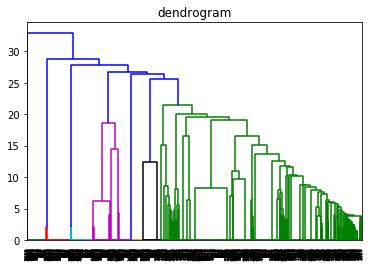

Top 5 unigrams and bigrams in

cluster 1:
pump
bush
bush pump
type
pump type

cluster 2:
borehole
deep
deep borehole
protected
protected deep

cluster 3:
spring
protected
protected spring
catchment
spring catchment

cluster 4:
well
dug
dug well
shallow
shallow well

cluster 5:
tank
rainwater
harvest
rainwater harvest
harvest tank

cluster 6:
mark
india
india mark
ghana
modified

cluster 7:
afridev
standpipe
pump
bucket
hand


In [3]:
stop_words=['used','driven','known','use','local','based','cause','fix','awaiting','removed',
            'coming', 'indicated','indicated','sent','limited','is','up','for','get']


df=pd.read_csv('Water_Point_Data_Exchange_Complete_Dataset.csv',low_memory=False)


wordnet_lemmatizer=WordNetLemmatizer()


df=missing_values(df,'#water_tech')
X, word_index=vectorizer(df, '#water_tech', maxdf=0.9, middf=3)
x, dist_array=pairwise_distance(X, size=2000)
Z=hierarchical_clustering(dist_array, method='ward')
C,j=cluster_assignments(Z, threshold=24)
print_results(x, j,word_index)